# Plasticity

## Problem definition

Elastoplastic materials, such as metals and engineering alloys, exhibit irreversible deformation behavior characterized by elastic-plastic coupling and path-dependent stress-strain relationships beyond the yield threshold. This example demostrate how to solve the J2 plasticity model [1] using JAX-FEM, with particular focus on the return mapping algorithm and incremental loading schemes that capture the nonlinear material response under displacement-controlled loading conditions.

For perfect J2-plasticity model [1], we assume that the total strain $\boldsymbol{\varepsilon}^{n-1}$ and stress $\boldsymbol{\sigma}^{n-1}$ from the previous loading step are known, and the problem states that find the displacement field $\boldsymbol{u}^n$ at the current loading step such that

$$
-\nabla \cdot \left( \boldsymbol{\sigma}^n(\nabla \boldsymbol{u}^n, \boldsymbol{\varepsilon}^{n-1}, \boldsymbol{\sigma}^{n-1}) \right) = \boldsymbol{b} \quad \text{in } \Omega,
$$

$$
\boldsymbol{u}^n = \boldsymbol{u}_D \quad \text{on } \Gamma_D,
$$

$$
\boldsymbol{\sigma}^n \cdot \boldsymbol{n} = \boldsymbol{t} \quad \text{on } \Gamma_N.
$$

The weak form gives

$$
\int_\Omega \boldsymbol{\sigma}^n : \nabla \boldsymbol{v} \, dx = \int_\Omega \boldsymbol{b} \cdot \boldsymbol{v} \, dx + \int_{\Gamma_N} \boldsymbol{t} \cdot \boldsymbol{v} \, ds.
$$

In this example, we consider a displacement-controlled uniaxial tensile loading condition. We assume free traction ($\boldsymbol{t} = [0,0,0]$) and ignore body force ($\boldsymbol{b} = [0,0,0]$). We assume quasi-static loadings from 0 to 0.1 mm and then unload from 0.1 mm to 0.

The stress $\boldsymbol{\sigma}^n$ is defined with the following relationships:

$$
\boldsymbol{\sigma}_{\text{trial}} = \boldsymbol{\sigma}^{n-1} + \Delta\boldsymbol{\sigma},
$$

$$
\Delta\boldsymbol{\sigma} = \lambda \text{tr}(\Delta\boldsymbol{\varepsilon})\boldsymbol{I} + 2\mu \Delta\boldsymbol{\varepsilon},
$$

$$
\Delta\boldsymbol{\varepsilon} = \boldsymbol{\varepsilon}^n - \boldsymbol{\varepsilon}^{n-1} = \frac{1}{2}\left[ \nabla \boldsymbol{u}^n + (\nabla \boldsymbol{u}^n)^T \right] - \boldsymbol{\varepsilon}^{n-1},
$$

$$
\boldsymbol{s} = \boldsymbol{\sigma}_{\text{trial}} - \frac{1}{3}\text{tr}(\boldsymbol{\sigma}_{\text{trial}})\boldsymbol{I},
$$

$$
s = \sqrt{\frac{3}{2}\boldsymbol{s}:\boldsymbol{s}},
$$

$$
f_{\text{yield}} = s - \sigma_{\text{yield}},
$$

$$
\boldsymbol{\sigma}^n = \boldsymbol{\sigma}_{\text{trial}} - \frac{\boldsymbol{s}}{s}\langle f_{\text{yield}} \rangle_+,
$$

where $\boldsymbol{\sigma}_{\text{trial}}$ is the elastic trial stress, $\boldsymbol{s}$ is the deviatoric part of $\boldsymbol{\sigma}_{\text{trial}}$, $f_{\text{yield}}$ is the yield function, $\sigma_{\text{yield}}$ is the yield strength, $\langle x \rangle_+ := \frac{1}{2}(x + |x|)$ is the ramp function, and $\boldsymbol{\sigma}^n$ is the stress at the current loading step.

## Implementation

First, we need to import some useful modules and jax_fem specific modules：

In [1]:
# Import some useful modules.
import jax
import jax.numpy as np
import os
import matplotlib.pyplot as plt


# Import JAX-FEM specific modules.
from jax_fem.problem import Problem
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh_gmsh, get_meshio_cell_type, Mesh

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



[12-03 17:05:54][INFO] jax_fem: pyamgx not installed. AMGX solver disabled.


### Weak form

In this J2 plasticity example, we use the **Laplace Kernel** to handle elastoplastic constitutive relations by overriding the `get_tensor_map` method to define the stress return mapping algorithm that enforces the von Mises yield criterion. 

The `custom_init()` method initializes internal variables `self.internal_vars = [self.sigmas_old, self.epsilons_old]` to store historical stress and strain states required for path-dependent plasticity computations. 

The `get_maps()` method implements the plasticity algorithms: `strain(u_grad)` computes the strain tensor from displacement gradients, while `stress_return_map(u_grad, sigma_old, epsilon_old)` performs the return mapping to project trial stresses back to the yield surface. The `update_stress_strain()` method advances the internal state variables after each loading increment, ensuring proper tracking of plastic deformation history essential for incremental plasticity formulations.

> It should be particularly noted that `stress_return_map(u_grad, sigma_old, epsilon_old)` takes two internal variables `sigma_old` and `epsilon_old`, and they MUST be correspondingly defined (and updated) using `self.internal_vars = [self.sigmas_old, self.epsilons_old]`. Otherwise, JAX-FEM will NOT know that there are two internal variables needed.

In [2]:
# Define constitutive relationship.
class Plasticity(Problem):
    # The function 'get_tensor_map' overrides base class method. Generally, JAX-FEM 
    # solves -div(f(u_grad,alpha_1,alpha_2,...,alpha_N)) = b. Here, we have 
    # f(u_grad,alpha_1,alpha_2,...,alpha_N) = sigma_crt(u_crt_grad, epsilon_old, sigma_old),
    # reflected by the function 'stress_return_map'
    def custom_init(self):
        # Override base class method.
        # Initializing total strain and stress.
        self.fe = self.fes[0]
        self.epsilons_old = np.zeros((len(self.fe.cells), self.fe.num_quads, self.fe.vec, self.dim))
        self.sigmas_old = np.zeros_like(self.epsilons_old)
        self.internal_vars = [self.sigmas_old, self.epsilons_old]

    def get_tensor_map(self):
        # Override base class method.
        _, stress_return_map = self.get_maps()
        return stress_return_map

    def get_maps(self):
        def safe_sqrt(x):  
            # np.sqrt is not differentiable at 0
            safe_x = np.where(x > 0., np.sqrt(x), 0.)
            return safe_x

        def safe_divide(x, y):
            return np.where(y == 0., 0., x/y)

        def strain(u_grad):
            epsilon = 0.5*(u_grad + u_grad.T)
            return epsilon

        def stress(epsilon):
            E = 70.e3
            nu = 0.3
            mu = E/(2.*(1. + nu))
            lmbda = E*nu/((1+nu)*(1-2*nu))
            sigma = lmbda*np.trace(epsilon)*np.eye(self.dim) + 2*mu*epsilon
            return sigma

        def stress_return_map(u_grad, sigma_old, epsilon_old):
            sig0 = 250.
            epsilon_crt = strain(u_grad)
            epsilon_inc = epsilon_crt - epsilon_old
            sigma_trial = stress(epsilon_inc) + sigma_old
            s_dev = sigma_trial - 1./self.dim*np.trace(sigma_trial)*np.eye(self.dim)
            s_norm = safe_sqrt(3./2.*np.sum(s_dev*s_dev))
            f_yield = s_norm - sig0
            f_yield_plus = np.where(f_yield > 0., f_yield, 0.)
            sigma = sigma_trial - safe_divide(f_yield_plus*s_dev, s_norm)
            return sigma
        return strain, stress_return_map

    def stress_strain_fns(self):
        strain, stress_return_map = self.get_maps()
        vmap_strain = jax.vmap(jax.vmap(strain))
        vmap_stress_return_map = jax.vmap(jax.vmap(stress_return_map))
        return vmap_strain, vmap_stress_return_map

    def update_stress_strain(self, sol):
        u_grads = self.fe.sol_to_grad(sol)
        vmap_strain, vmap_stress_rm = self.stress_strain_fns()
        self.sigmas_old = vmap_stress_rm(u_grads, self.sigmas_old, self.epsilons_old)
        self.epsilons_old = vmap_strain(u_grads)
        self.internal_vars = [self.sigmas_old, self.epsilons_old]

    def compute_avg_stress(self):
        # For post-processing only: Compute volume averaged stress.
        # (num_cells*num_quads, vec, dim) * (num_cells*num_quads, 1, 1) -> (vec, dim)
        sigma = np.sum(self.sigmas_old.reshape(-1, self.fe.vec, self.dim) * self.fe.JxW.reshape(-1)[:, None, None], 0)
        vol = np.sum(self.fe.JxW)
        avg_sigma = sigma/vol
        return avg_sigma

### Mesh

Here we use the first-order hexahedron element `HEX8` to discretize the computational domain:

In [6]:
# Specify mesh-related information.
ele_type = 'HEX8'
cell_type = get_meshio_cell_type(ele_type)
import os

# 定义 data 文件夹路径
data_dir = os.path.join(os.getcwd(), 'data')
os.makedirs(data_dir, exist_ok=True)
os.makedirs(os.path.join(data_dir, 'vtk'), exist_ok=True)

Lx, Ly, Lz = 10., 10., 10.
Nx, Ny, Nz = 10, 10, 10

meshio_mesh = box_mesh_gmsh(
    Nx=Nx,
    Ny=Ny,
    Nz=Nz,
    domain_x=Lx,
    domain_y=Ly,
    domain_z=Lz,
    data_dir=data_dir,
    ele_type=ele_type,
)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Extruded)
Info    : [ 10%] Meshing curve 2 (Extruded)
Info    : [ 20%] Meshing curve 3 (Extruded)
Info    : [ 30%] Meshing curve 4 (Extruded)
Info    : [ 40%] Meshing curve 7 (Extruded)
Info    : [ 50%] Meshing curve 8 (Extruded)
Info    : [ 60%] Meshing curve 9 (Extruded)
Info    : [ 60%] Meshing curve 10 (Extruded)
Info    : [ 70%] Meshing curve 12 (Extruded)
Info    : [ 80%] Meshing curve 13 (Extruded)
Info    : [ 90%] Meshing curve 17 (Extruded)
Info    : [100%] Meshing curve 21 (Extruded)
Info    : Done meshing 1D (Wall 0.000551361s, CPU 0.000578s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 5 (Extruded)
Info    : [ 20%] Meshing surface 14 (Extruded)
Info    : [ 40%] Meshing surface 18 (Extruded)
Info    : [ 60%] Meshing surface 22 (Extruded)
Info    : [ 70%] Meshing surface 26 (Extruded)
Info    : [ 90%] Meshing surface 27 (Extruded)
Info    : Done meshing 2D (Wall 0.00709367s, CPU 0.003264s)
Info    : Meshing

### Boundary conditions

The boundary conditions implement a displacement-controlled uniaxial tensile test: the bottom surface ($z=0$) is fixed with zero displacement constraint `dirichlet_val_bottom(point) = 0`, while the top surface ($z=L_z$) undergoes prescribed displacement loading through `get_dirichlet_top(disp)`. The loading sequence `disps` defines a loading-unloading cycle from 0 to 0.1 mm followed by unloading back to 0, with both constraints applied to the z-component (`vecs = [2, 2]`) to simulate the uniaxial tension.

In [7]:
# Define boundary locations.
def top(point):
    return np.isclose(point[2], Lz, atol=1e-5)

def bottom(point):
    return np.isclose(point[2], 0., atol=1e-5)

# Define Dirichlet boundary values.
# We fix the z-component of the displacement field to be zero on the 'bottom' 
# side, and control the z-component on the 'top' side.
def dirichlet_val_bottom(point):
    return 0.

def get_dirichlet_top(disp):
    def val_fn(point):
        return disp
    return val_fn

disps = np.hstack((np.linspace(0., 0.1, 11), np.linspace(0.09, 0., 10)))

location_fns = [bottom, top]
value_fns = [dirichlet_val_bottom, get_dirichlet_top(disps[0])]
vecs = [2, 2]

dirichlet_bc_info = [location_fns, vecs, value_fns]

W1203 17:14:36.941910    2929 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1203 17:14:36.980861     993 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


### Problem

We have completed all the preliminary preparations for the problem. Then we can proceed to create an instance of our BVP:

In [8]:
problem = Plasticity(mesh, vec=3, dim=3, dirichlet_bc_info=dirichlet_bc_info)

[12-03 17:14:42][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[12-03 17:14:42][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[12-03 17:14:42][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[12-03 17:14:43][DEBUG] jax_fem: Done pre-computations, took 1.2827939987182617 [s]
[12-03 17:14:43][INFO] jax_fem: Solving a problem with 1000 cells, 1331x3 = 3993 dofs.
[12-03 17:14:43][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


### Solver

The defined BVP is solved incrementally using `solver()` for each displacement step in the loading-unloading cycle. Here, we employ the Newton-Raphson method with `PETSc` solver, where the internal stress-strain states are updated after each converged solution via `problem.update_stress_strain()`. 

In [9]:
avg_stresses = []

for i, disp in enumerate(disps):
    print(f"\nStep {i} in {len(disps)}, disp = {disp}")
    dirichlet_bc_info[-1][-1] = get_dirichlet_top(disp)
    problem.fe.update_Dirichlet_boundary_conditions(dirichlet_bc_info)
    sol_list = solver(problem, solver_options={'petsc_solver': {}})
    problem.update_stress_strain(sol_list[0])
    avg_stress = problem.compute_avg_stress()
    print(avg_stress)
    avg_stresses.append(avg_stress)
    vtk_path = os.path.join(data_dir, f'vtk/u_{i:03d}.vtu')
    save_sol(problem.fe, sol_list[0], vtk_path)

avg_stresses = np.array(avg_stresses)

[12-03 17:14:56][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[12-03 17:14:56][DEBUG] jax_fem: Start timing
[12-03 17:14:56][DEBUG] jax_fem: Computing cell Jacobian and cell residual...



Step 0 in 21, disp = 0.0


[12-03 17:14:58][DEBUG] jax_fem: Function split_and_compute_cell took 1.9002 seconds
[12-03 17:14:59][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:14:59][DEBUG] jax_fem: Before, l_2 res = 0.0, relative l_2 res = nan
[12-03 17:15:00][INFO] jax_fem: Solve took 3.3212225437164307 [s]
[12-03 17:15:00][INFO] jax_fem: max of dofs = 0.0
[12-03 17:15:00][INFO] jax_fem: min of dofs = 0.0
[12-03 17:15:01][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[12-03 17:15:01][DEBUG] jax_fem: Start timing
[12-03 17:15:01][DEBUG] jax_fem: Computing cell Jacobian and cell residual...


[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Step 1 in 21, disp = 0.010000000000000002


[12-03 17:15:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.2136 seconds
[12-03 17:15:02][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:02][DEBUG] jax_fem: Before, l_2 res = 0.11000000000000003, relative l_2 res = 1.0
[12-03 17:15:02][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:02][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:02][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0005533981470107239
[12-03 17:15:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.2022 seconds
[12-03 17:15:02][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:02][DEBUG] jax_fem: l_2 res = 0.0005533981470558304, relative l_2 res = 0.005030892245962093
[12-03 17:15:02][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:02][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = 

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. 70.]]

Step 2 in 21, disp = 0.020000000000000004


[12-03 17:15:03][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:03][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:03][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0011067962940214478
[12-03 17:15:03][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:03][DEBUG] jax_fem: Function split_and_compute_cell took 0.1062 seconds
[12-03 17:15:03][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:03][DEBUG] jax_fem: l_2 res = 0.0011067962941070614, relative l_2 res = 0.005030892245941187
[12-03 17:15:03][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:03][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:03][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 8.053496553054187e-09
[12-03 17:15:03][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:03][DEBUG] jax_fem: Function split_a

[[  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0. 140.]]

Step 3 in 21, disp = 0.030000000000000006


[12-03 17:15:03][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:03][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0016601944450632948
[12-03 17:15:03][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:03][DEBUG] jax_fem: Function split_and_compute_cell took 0.1035 seconds
[12-03 17:15:03][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:04][DEBUG] jax_fem: l_2 res = 0.001660194445127644, relative l_2 res = 0.005030892257962556
[12-03 17:15:04][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:04][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:04][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 1.2080249220540828e-08
[12-03 17:15:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.1068 seconds
[12-03 17:15:04][DEBUG

[[  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0. 210.]]

Step 4 in 21, disp = 0.04000000000000001


[12-03 17:15:04][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:04][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.002213592588565531
[12-03 17:15:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.1788 seconds
[12-03 17:15:04][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:04][DEBUG] jax_fem: l_2 res = 189.99993178520785, relative l_2 res = 431.8180267845632
[12-03 17:15:04][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:04][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:04][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 9.703749321532158e-05
[12-03 17:15:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.1677 seconds
[12-03 17:15:05][DEBUG] jax_f

[[ -0.   0.   0.]
 [  0.  -0.   0.]
 [  0.   0. 250.]]

Step 5 in 21, disp = 0.05000000000000001


[12-03 17:15:05][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:05][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.002792994089705008
[12-03 17:15:05][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:05][DEBUG] jax_fem: Function split_and_compute_cell took 0.1264 seconds
[12-03 17:15:05][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:05][DEBUG] jax_fem: l_2 res = 443.33324246824645, relative l_2 res = 2.0222154439116133
[12-03 17:15:05][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:05][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:05][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 8.024283238974816e-05
[12-03 17:15:05][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:05][DEBUG] jax_fem: Function split_and_compute_cell took 0.1013 seconds
[12-03 17:15:05][DEBUG] jax_

[[ -0.  -0.   0.]
 [ -0.   0.  -0.]
 [  0.  -0. 250.]]

Step 6 in 21, disp = 0.06000000000000001


[12-03 17:15:06][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:06][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.003354273512531646
[12-03 17:15:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.1062 seconds
[12-03 17:15:06][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:06][DEBUG] jax_fem: l_2 res = 443.3332169811865, relative l_2 res = 0.6066662600209083
[12-03 17:15:06][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:06][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:06][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 8.017744194462644e-05
[12-03 17:15:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.1123 seconds
[12-03 17:15:06][DEBUG] jax_f

[[  0.  -0.   0.]
 [ -0.   0.   0.]
 [  0.   0. 250.]]

Step 7 in 21, disp = 0.07


[12-03 17:15:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.1700 seconds
[12-03 17:15:07][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:07][DEBUG] jax_fem: Before, l_2 res = 1242.3079309361565, relative l_2 res = 1.0
[12-03 17:15:07][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:07][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:07][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0038780985275790104
[12-03 17:15:07][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.1140 seconds
[12-03 17:15:07][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:07][DEBUG] jax_fem: l_2 res = 443.33319856024747, relative l_2 res = 0.3568625680640775
[12-03 17:15:07][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:07][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,

[[ -0.  -0.   0.]
 [ -0.   0.   0.]
 [  0.   0. 250.]]

Step 8 in 21, disp = 0.08000000000000002


[12-03 17:15:09][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:09][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.038344523474686795
[12-03 17:15:09][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:09][DEBUG] jax_fem: Function split_and_compute_cell took 0.1050 seconds
[12-03 17:15:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:10][DEBUG] jax_fem: l_2 res = 3166.667464496436, relative l_2 res = 2.000000194990539
[12-03 17:15:10][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:10][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:10][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0007595489589503939
[12-03 17:15:10][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.0974 seconds
[12-03 17:15:10][DEBUG] jax_fe

[[  0.   0.  -0.]
 [  0.   0.   0.]
 [ -0.   0. 250.]]

Step 9 in 21, disp = 0.09000000000000002


[12-03 17:15:10][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:10][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.025736491553802362
[12-03 17:15:10][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.1017 seconds
[12-03 17:15:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:10][DEBUG] jax_fem: l_2 res = 3166.666557381696, relative l_2 res = 1.9999995400236887
[12-03 17:15:10][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:10][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:10][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0006361552880475177
[12-03 17:15:10][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:11][DEBUG] jax_fem: Function split_and_compute_cell took 0.1672 seconds
[12-03 17:15:11][DEBUG] jax_f

[[ -0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0. 250.]]

Step 10 in 21, disp = 0.1


[12-03 17:15:11][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:11][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.003965882581258224
[12-03 17:15:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:11][DEBUG] jax_fem: Function split_and_compute_cell took 0.1022 seconds
[12-03 17:15:11][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:11][DEBUG] jax_fem: l_2 res = 3166.6665506714367, relative l_2 res = 1.9999994440814697
[12-03 17:15:11][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:11][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:12][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.000785547805968031
[12-03 17:15:12][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.0978 seconds
[12-03 17:15:12][DEBUG] jax_f

[[  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0. 250.]]

Step 11 in 21, disp = 0.09


[12-03 17:15:12][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:12][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.07165140054264729
[12-03 17:15:12][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.0945 seconds
[12-03 17:15:12][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:12][DEBUG] jax_fem: l_2 res = 3142.30985454338, relative l_2 res = 1.9846163622912805
[12-03 17:15:12][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:12][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:12][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0024845411817854845
[12-03 17:15:12][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.1086 seconds
[12-03 17:15:12][DEBUG] jax_fem

[[ -0.  -0.  -0.]
 [ -0.  -0.  -0.]
 [ -0.  -0. 180.]]

Step 12 in 21, disp = 0.07999999999999999


[12-03 17:15:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.1712 seconds
[12-03 17:15:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:13][DEBUG] jax_fem: Before, l_2 res = 1583.333577880533, relative l_2 res = 1.0
[12-03 17:15:13][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:13][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:13][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.06475739098306474
[12-03 17:15:13][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.1272 seconds
[12-03 17:15:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:13][DEBUG] jax_fem: l_2 res = 2630.7700845726667, relative l_2 res = 1.661538744156644
[12-03 17:15:13][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:13][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc 

[[ -0.  -0.  -0.]
 [ -0.  -0.  -0.]
 [ -0.  -0. 110.]]

Step 13 in 21, disp = 0.06999999999999999


[12-03 17:15:14][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:14][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.06470985426096101
[12-03 17:15:14][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:14][DEBUG] jax_fem: Function split_and_compute_cell took 0.0928 seconds
[12-03 17:15:14][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:14][DEBUG] jax_fem: l_2 res = 2119.2310317550423, relative l_2 res = 1.3384615459913614
[12-03 17:15:14][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:14][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:14][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0018968416868635116
[12-03 17:15:14][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:14][DEBUG] jax_fem: Function split_and_compute_cell took 0.0938 seconds
[12-03 17:15:14][DEBUG] jax_f

[[ 0.  0. -0.]
 [ 0. -0. -0.]
 [-0. -0. 40.]]

Step 14 in 21, disp = 0.060000000000000005


[12-03 17:15:15][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0030119202556637714
[12-03 17:15:15][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:15][DEBUG] jax_fem: Function split_and_compute_cell took 0.0930 seconds
[12-03 17:15:15][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:15][DEBUG] jax_fem: l_2 res = 1607.6923489052551, relative l_2 res = 1.0153845531986851
[12-03 17:15:15][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:15][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:15][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0012144553515535345
[12-03 17:15:15][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:15][DEBUG] jax_fem: Function split_and_compute_cell took 0.1739 seconds
[12-03 17:15:15][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:15][DEBUG] jax_fem: l_2 res = 0.00121445535137

[[ -0.  -0.  -0.]
 [ -0.  -0.  -0.]
 [ -0.  -0. -30.]]

Step 15 in 21, disp = 0.05


[12-03 17:15:16][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0034283511819620475
[12-03 17:15:16][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:16][DEBUG] jax_fem: Function split_and_compute_cell took 0.0920 seconds
[12-03 17:15:16][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:16][DEBUG] jax_fem: l_2 res = 1096.1538730665561, relative l_2 res = 0.6923076675366701
[12-03 17:15:16][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:16][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:16][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0008636031877124553
[12-03 17:15:16][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:16][DEBUG] jax_fem: Function split_and_compute_cell took 0.0930 seconds
[12-03 17:15:16][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:16][DEBUG] jax_fem: l_2 res = 0.00086360318769

[[  -0.   -0.   -0.]
 [  -0.    0.   -0.]
 [  -0.   -0. -100.]]

Step 16 in 21, disp = 0.039999999999999994


[12-03 17:15:17][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.015872194979376437
[12-03 17:15:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.1000 seconds
[12-03 17:15:17][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:17][DEBUG] jax_fem: l_2 res = 584.6153954346574, relative l_2 res = 0.3692307618070171
[12-03 17:15:17][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:17][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:17][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.0006476457783899611
[12-03 17:15:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.0928 seconds
[12-03 17:15:17][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:17][DEBUG] jax_fem: l_2 res = 0.0006476457784755

[[   0.   -0.   -0.]
 [  -0.   -0.   -0.]
 [  -0.   -0. -170.]]

Step 17 in 21, disp = 0.030000000000000002


[12-03 17:15:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.1822 seconds
[12-03 17:15:17][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:18][DEBUG] jax_fem: Before, l_2 res = 1583.3333677226572, relative l_2 res = 1.0
[12-03 17:15:18][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:18][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:18][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.020679222920416553
[12-03 17:15:18][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.1612 seconds
[12-03 17:15:18][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:18][DEBUG] jax_fem: l_2 res = 73.07728275740915, relative l_2 res = 0.046154072318022196
[12-03 17:15:18][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:18][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl,

[[  -0.    0.   -0.]
 [   0.    0.   -0.]
 [  -0.   -0. -240.]]

Step 18 in 21, disp = 0.020000000000000007


[12-03 17:15:19][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:19][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:19][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.009101359485741232
[12-03 17:15:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.1035 seconds
[12-03 17:15:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:19][DEBUG] jax_fem: l_2 res = 0.01230960168784573, relative l_2 res = 7.774485201486331e-06
[12-03 17:15:19][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:19][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:19][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 2.566691520437905e-08
[12-03 17:15:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:19][DEBUG] jax_fem: Function split_and

[[   0.    0.    0.]
 [   0.   -0.    0.]
 [   0.    0. -250.]]

Step 19 in 21, disp = 0.010000000000000004


[12-03 17:15:19][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:19][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.00382864761135138
[12-03 17:15:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.1017 seconds
[12-03 17:15:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:19][DEBUG] jax_fem: l_2 res = 0.004428334927915548, relative l_2 res = 2.796843105618299e-06
[12-03 17:15:19][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:19][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:19][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 6.0236533491913336e-09
[12-03 17:15:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.1646 seconds
[12-03 17:15:20][DEBUG]

[[   0.    0.   -0.]
 [   0.   -0.   -0.]
 [  -0.   -0. -250.]]

Step 20 in 21, disp = 0.0


[12-03 17:15:20][DEBUG] jax_fem: Before, l_2 res = 1583.3333333331666, relative l_2 res = 1.0
[12-03 17:15:20][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:20][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:20][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 0.00022728510086221756
[12-03 17:15:20][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-03 17:15:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.0961 seconds
[12-03 17:15:20][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-03 17:15:20][DEBUG] jax_fem: l_2 res = 0.00027209576781517887, relative l_2 res = 1.7184995862013106e-07
[12-03 17:15:20][DEBUG] jax_fem: Solving linear system...
[12-03 17:15:20][DEBUG] jax_fem: PETSc Solver - Solving linear system with ksp_type = bcgsl, pc = ilu
[12-03 17:15:20][DEBUG] jax_fem: PETSc Solver - Finished solving, linear solve res = 1.1625075610265868e-08
[12-03 17:15:20][DEBUG] jax_

[[  -0.   -0.    0.]
 [  -0.   -0.   -0.]
 [   0.   -0. -250.]]


### Postprocessing

The solution can be exported to VTK format files (readable by ParaView and other post-processing software) using `jax_fem`'s built-in function `save_sol`:

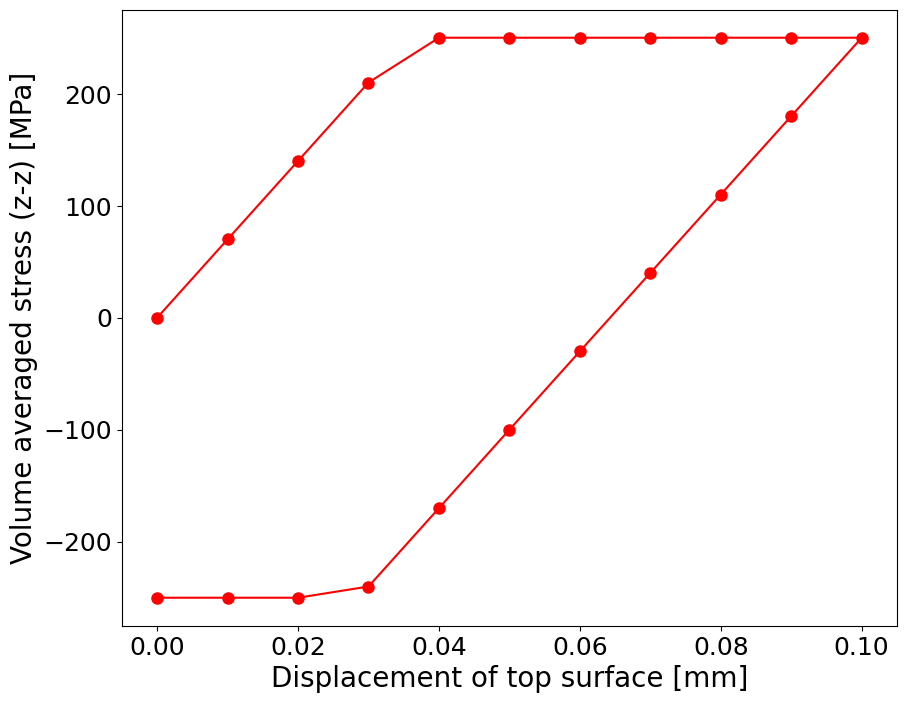

In [10]:
# Plot the volume-averaged stress versus the vertical displacement of the top surface.
fig = plt.figure(figsize=(10, 8))
plt.plot(disps, avg_stresses[:, 2, 2], color='red', marker='o', markersize=8, linestyle='-') 
plt.xlabel(r'Displacement of top surface [mm]', fontsize=20)
plt.ylabel(r'Volume averaged stress (z-z) [MPa]', fontsize=20)
plt.tick_params(labelsize=18)
plt.show()

<center>
  <img src="../../_static/images/plasticity.gif" width="400" />
  <p><em>z-z component of volume-averaged stress versus displacement of the top surface.</em></p>
</center>

<center>
  <img src="../../_static/images/plasticity_curve.png" width="400" />
  <p><em>Stress-strain curve.</em></p>
</center>

> Please refer to this [link](https://github.com/deepmodeling/jax-fem/blob/main/docs/source/learn/plasticity/example.ipynb) to download the source file.

## References

1. [Simo, Juan C., and Thomas JR Hughes. Computational inelasticity. Vol. 7. Springer Science & Business Media, 2006.](https://books.google.com/books/about/Computational_Inelasticity.html?id=EILbBwAAQBAJ)

2. [Xue, Tianju, et al. "JAX-FEM: A differentiable GPU-accelerated 3D finite element solver for automatic inverse design and mechanistic data science." Computer Physics Communications (2023): 108802.](https://www.sciencedirect.com/science/article/abs/pii/S0010465523001479)